In [2]:
from tensorflow.keras.layers import Conv2D,Flatten,Dense,MaxPool2D,GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from tensorflow import keras 
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
import sklearn
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import tensorflow

EXTRACTION OF PRETRAINED NETWORK FROM KERAS


In [3]:
img_height, img_width = (224,224)
batch_size = 32
IMG_SHAPE = (img_height, img_width, 3)#1ST CHANGE
train_data_dir = r"C:/Users/Janani/GAIP_NUS/Eye Motion/Output_folder/train"
valid_data_dir = r"C:/Users/Janani/GAIP_NUS/Eye Motion/Output_folder/val"
test_data_dir = r"C:/Users/Janani/GAIP_NUS/Eye Motion/Output_folder/test"
#test_data_dir = r"/content/drive/MyDrive/outputfolder/test"
#image.open()

In [4]:

train_datagen = ImageDataGenerator(
                                   shear_range=0.2,zoom_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.4)
                                   # rescale=1/255)

train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size = batch_size, 
                                                    class_mode='categorical')
                                                 #   subset='training')# set as training data

valid_generator = train_datagen.flow_from_directory(valid_data_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size = batch_size, 
                                                    class_mode='categorical')
                                                    #subset='validation') #set as validation data  
                                                                  

Found 3221 images belonging to 4 classes.
Found 399 images belonging to 4 classes.


In [5]:
train_generator.class_indices

{'Closed Eyes': 0,
 'center_eyes_aug': 1,
 'left_eyes_aug': 2,
 'right_eyes_aug': 3}

In [6]:
y_train = train_generator.classes
len(y_train)

3221

In [7]:
nb_validation_samples = 399

In [8]:
dir(train_generator)
#type(train_generator.labels)
print(train_generator.classes)
#y_train = train_generator.classes
y_train = train_generator.classes
y_train.shape

[0 0 0 ... 3 3 3]


(3221,)

In [54]:
test_generator = train_datagen.flow_from_directory(test_data_dir,
                                                    target_size=(img_height, img_width),
                                   
                                                   batch_size = 1, 
                                                    class_mode='categorical')
                                                    #subset='validation') #set as testing data

Found 404 images belonging to 4 classes.


In [55]:
x,y = test_generator.next()
print(x.shape)
#print(type(x))
#x
print(y.shape)

(1, 224, 224, 3)
(1, 4)


MOBILENETV2
ARCHITECTURE

In [21]:
def create_model():

  base_model_3 = MobileNetV2(include_top = False, weights='imagenet',input_shape=IMG_SHAPE)#2ND CHANGE
 
 #the top layer is false coz we want to classify our own classes
#we use weights from imagenet(pre-trained weights) to classify our model
  x = base_model_3.output
#taking the top layer of Resnet50 and connecting with dense layers
  x = GlobalAveragePooling2D()(x)

  x = Dense(1024, activation='relu')(x)
  predictions = Dense(train_generator.num_classes, activation='softmax')(x)
  model = Model(inputs=base_model_3.input, outputs=predictions)

  for layer in base_model_3.layers:
    layer.trainable = False
    
  opt = keras.optimizers.Adam(learning_rate=0.0001)#learning rate as 0.01
  model.compile(loss='categorical_crossentropy', optimizer=opt,
               metrics = ['accuracy','mse'])

  #model.compile(optimizer='adam', loss='categorical_crossentropy', 
            #   metrics = ['accuracy','mse'])
 # model.fit(train_generator, epochs = 10)
  return model

model = create_model()
model.summary()

#plot_model(model, show_layer_names=True, show_shapes =True, to_file='model.png', dpi=350)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

In [ ]:
model

In [22]:
# 50 epochs for Mobilenet model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

#checkpointing
#checkpoint_path = "/content/drive/MyDrive/cp-0021.ckpt.data-00000-of-00001"
checkpoint_path = "C:/Users/Janani/GAIP_NUS/Eye Motion/cp-0021.ckpt.data-00000-of-00001"
checkpoint_dir = os.path.dirname(checkpoint_path)

#Create a callback that saves the model's weights
cp_callback = tensorflow.keras.callbacks.ModelCheckpoint(monitor = 'val_accuracy',
   filepath=checkpoint_path, 
    verbose=1,
    save_weights_only=True,
    #save_freq=5*batch_size,
     save_best_only = True,                                                    
      mode='max')


#Reduce learning rate when a metric has stopped improving.
# Models often benefit 
#from reducing the learning rate by a factor of 2-10
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.2, patience=2, min_lr=0.00001)



# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

# Train the model with the new callback
model_history = model.fit(train_generator, epochs = 50,callbacks=[cp_callback, reduce_lr],
                          validation_data=valid_generator,
    validation_steps=nb_validation_samples // batch_size)
           # Pass callback to training

Epoch 1/50
101/101 [==============================] - ETA: 0s - loss: 1.1704 - accuracy: 0.4480 - mse: 0.1614
Epoch 1: val_accuracy improved from -inf to 0.51042, saving model to C:/Users/Janani/GAIP_NUS/Eye Motion\cp-0021.ckpt.data-00000-of-00001
101/101 [==============================] - 201s 2s/step - loss: 1.1704 - accuracy: 0.4480 - mse: 0.1614 - val_loss: 1.0435 - val_accuracy: 0.5104 - val_mse: 0.1468 - lr: 1.0000e-04
Epoch 2/50
101/101 [==============================] - ETA: 0s - loss: 1.0181 - accuracy: 0.5340 - mse: 0.1423
Epoch 2: val_accuracy improved from 0.51042 to 0.56510, saving model to C:/Users/Janani/GAIP_NUS/Eye Motion\cp-0021.ckpt.data-00000-of-00001
101/101 [==============================] - 154s 2s/step - loss: 1.0181 - accuracy: 0.5340 - mse: 0.1423 - val_loss: 0.9489 - val_accuracy: 0.5651 - val_mse: 0.1354 - lr: 1.0000e-04
Epoch 3/50
101/101 [==============================] - ETA: 0s - loss: 0.9633 - accuracy: 0.5424 - mse: 0.1362
Epoch 3: val_accuracy did not

101/101 [==============================] - 91s 899ms/step - loss: 0.8191 - accuracy: 0.6290 - mse: 0.1171 - val_loss: 0.8236 - val_accuracy: 0.6224 - val_mse: 0.1191 - lr: 1.0000e-05
Epoch 24/50
101/101 [==============================] - ETA: 0s - loss: 0.8086 - accuracy: 0.6278 - mse: 0.1156
Epoch 24: val_accuracy did not improve from 0.62240
101/101 [==============================] - 91s 896ms/step - loss: 0.8086 - accuracy: 0.6278 - mse: 0.1156 - val_loss: 0.8985 - val_accuracy: 0.5599 - val_mse: 0.1280 - lr: 1.0000e-05
Epoch 25/50
101/101 [==============================] - ETA: 0s - loss: 0.8075 - accuracy: 0.6355 - mse: 0.1153
Epoch 25: val_accuracy did not improve from 0.62240
101/101 [==============================] - 91s 896ms/step - loss: 0.8075 - accuracy: 0.6355 - mse: 0.1153 - val_loss: 0.8655 - val_accuracy: 0.6068 - val_mse: 0.1240 - lr: 1.0000e-05
Epoch 26/50
101/101 [==============================] - ETA: 0s - loss: 0.8156 - accuracy: 0.6256 - mse: 0.1168
Epoch 26: val_

Epoch 47/50
101/101 [==============================] - ETA: 0s - loss: 0.7740 - accuracy: 0.6458 - mse: 0.1107
Epoch 47: val_accuracy did not improve from 0.62500
101/101 [==============================] - 91s 899ms/step - loss: 0.7740 - accuracy: 0.6458 - mse: 0.1107 - val_loss: 0.8378 - val_accuracy: 0.6224 - val_mse: 0.1207 - lr: 1.0000e-05
Epoch 48/50
101/101 [==============================] - ETA: 0s - loss: 0.7702 - accuracy: 0.6526 - mse: 0.1101
Epoch 48: val_accuracy did not improve from 0.62500
101/101 [==============================] - 91s 898ms/step - loss: 0.7702 - accuracy: 0.6526 - mse: 0.1101 - val_loss: 0.8565 - val_accuracy: 0.5938 - val_mse: 0.1236 - lr: 1.0000e-05
Epoch 49/50
101/101 [==============================] - ETA: 0s - loss: 0.7704 - accuracy: 0.6529 - mse: 0.1103
Epoch 49: val_accuracy did not improve from 0.62500
101/101 [==============================] - 91s 896ms/step - loss: 0.7704 - accuracy: 0.6529 - mse: 0.1103 - val_loss: 0.8537 - val_accuracy: 0.60

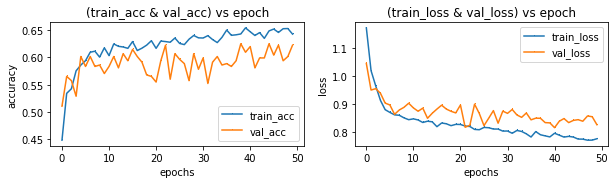

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [24]:
def plot_accuracy_loss(history):
    
    fig = plt.figure(figsize=(10,5))

    plt.subplot(221)
    #plt.plot(history.history['accuracy'],'bo--', label = "train_acc")
    plt.plot(history.history['accuracy'],marker = ',',ms = 10, label = "train_acc")
    plt.plot(history.history['val_accuracy'], marker = ',', label = "val_acc")
    plt.title("(train_acc & val_acc) vs epoch")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    plt.subplot(222)
    plt.plot(history.history['loss'],marker= ',', label = "train_loss")
    plt.plot(history.history['val_loss'], marker=',' , label = "val_loss")
    plt.title("(train_loss & val_loss) vs epoch")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    f = plt.figure()
    plt.show()
  


plot_accuracy_loss(model_history)
f = plt.figure()
f.savefig('C:/Users/Janani/GAIP_NUS/Eye Motion', bbox_inches='tight', dpi=600)

1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 52ms/step


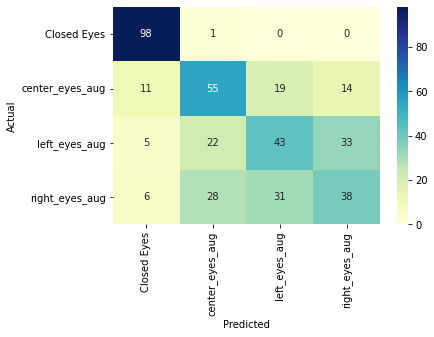

test accuracy: 57.920792079207914


In [26]:
#to plot confusion matrix for 100 epochs
import pandas as pd
import seaborn as sn
import tensorflow as tf

#model = tf.keras.models.load_model("Reflection_dataset\Saved_Model\Mobilenet_reflection.h5")
model_1 = model
filenames = test_generator.filenames
nb_samples = len(test_generator)
y_prob=[]
y_act=[]
test_generator.reset()
for _ in range(nb_samples):
  X_test,Y_test = test_generator.next()
  y_prob.append(model.predict(X_test))
  y_act.append(Y_test)

predicted_class = [list(train_generator.class_indices.keys())[i.argmax()]for i in y_prob]
actual_class = [list(train_generator.class_indices.keys())[i.argmax()]for i in y_act]

out_df = pd.DataFrame(np.vstack([predicted_class,actual_class]).T,columns = ['predicted_class','actual_class'])
confusion_matrix = pd.crosstab(out_df['actual_class'],out_df['predicted_class'], rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix,cmap="YlGnBu", annot = True,fmt='d')
plt.show()
print('test accuracy: {}'.format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100)))

In [28]:
target = []
for x in train_generator.class_indices.keys():
  target.append(x)

target

['Closed Eyes', 'center_eyes_aug', 'left_eyes_aug', 'right_eyes_aug']

ROC AUC score: 0.7260700330130283


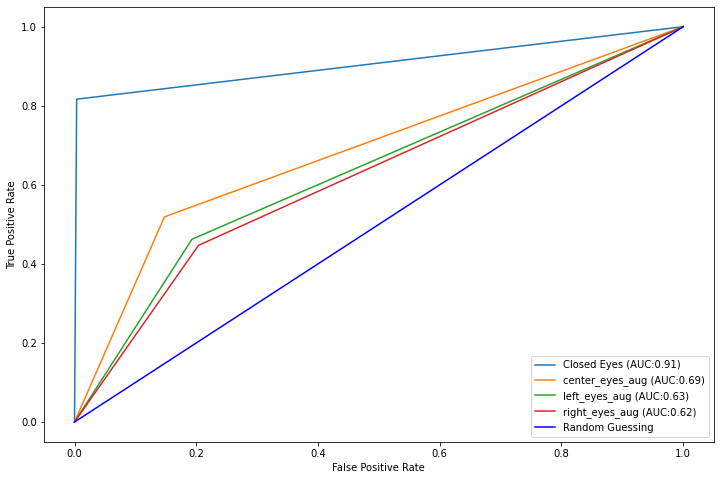

In [29]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score


#target= ['airplane', 'automobile', 'bird', 'cat', 'deer',
   #       'dog', 'frog', 'horse', 'ship', 'truck']

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, ypred, average="weighted"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    ypred = lb.transform(ypred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), ypred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, ypred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(predicted_class, actual_class))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

In [ ]:
#for image augmentation 

In [30]:
model.save('mobilenetv2.h5')

In [68]:
#load the model
model_1 = tensorflow.keras.models.load_model('mobilenetv2.h5')

In [13]:
result = model_1.evaluate(test_generator)
dict(zip(model_1.metrics_names, result))

404/404 [==============================] - 17s 38ms/step - loss: 0.8724 - accuracy: 0.5767 - mse: 0.1273


{'loss': 0.8723741173744202,
 'accuracy': 0.5767326951026917,
 'mse': 0.1272774338722229}

In [59]:
#finetuning
for layer in model_1.layers:
    layer.trainable = True
    print("number of layers in model_1:", len(model_1.layers))
    fine_tune_at = 120
for layer in model_1.layers[:fine_tune_at]:
    layer.trainable = False

opt = keras.optimizers.Adam(learning_rate=0.00001)#learning rate as 0.01
model_1.compile(loss='categorical_crossentropy', optimizer=opt,
               metrics = ['accuracy','mse'])

model = model_1
model.summary()

number of layers in model_1: 157
number of layers in model_1: 157
number of layers in model_1: 157
number of layers in model_1: 157
number of layers in model_1: 157
number of layers in model_1: 157
number of layers in model_1: 157
number of layers in model_1: 157
number of layers in model_1: 157
number of layers in model_1: 157
number of layers in model_1: 157
number of layers in model_1: 157
number of layers in model_1: 157
number of layers in model_1: 157
number of layers in model_1: 157
number of layers in model_1: 157
number of layers in model_1: 157
number of layers in model_1: 157
number of layers in model_1: 157
number of layers in model_1: 157
number of layers in model_1: 157
number of layers in model_1: 157
number of layers in model_1: 157
number of layers in model_1: 157
number of layers in model_1: 157
number of layers in model_1: 157
number of layers in model_1: 157
number of layers in model_1: 157
number of layers in model_1: 157
number of layers in model_1: 157
number of 

                                )                                ]                                
                                                                                                  
 block_1_expand_BN (BatchNormal  (None, 112, 112, 96  384        ['block_1_expand[0][0]']         
 ization)                       )                                                                 
                                                                                                  
 block_1_expand_relu (ReLU)     (None, 112, 112, 96  0           ['block_1_expand_BN[0][0]']      
                                )                                                                 
                                                                                                  
 block_1_pad (ZeroPadding2D)    (None, 113, 113, 96  0           ['block_1_expand_relu[0][0]']    
                                )                                                                 
          

                                                                                                  
 block_4_project (Conv2D)       (None, 28, 28, 32)   6144        ['block_4_depthwise_relu[0][0]'] 
                                                                                                  
 block_4_project_BN (BatchNorma  (None, 28, 28, 32)  128         ['block_4_project[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_4_add (Add)              (None, 28, 28, 32)   0           ['block_3_project_BN[0][0]',     
                                                                  'block_4_project_BN[0][0]']     
                                                                                                  
 block_5_expand (Conv2D)        (None, 28, 28, 192)  6144        ['block_4_add[0][0]']            
          

                                                                                                  
 block_8_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_8_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_8_depthwise_BN (BatchNor  (None, 14, 14, 384)  1536       ['block_8_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_8_depthwise_relu (ReLU)  (None, 14, 14, 384)  0           ['block_8_depthwise_BN[0][0]']   
                                                                                                  
 block_8_project (Conv2D)       (None, 14, 14, 64)   24576       ['block_8_depthwise_relu[0][0]'] 
          

 block_12_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_11_add[0][0]']           
                                                                                                  
 block_12_expand_BN (BatchNorma  (None, 14, 14, 576)  2304       ['block_12_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_12_expand_relu (ReLU)    (None, 14, 14, 576)  0           ['block_12_expand_BN[0][0]']     
                                                                                                  
 block_12_depthwise (DepthwiseC  (None, 14, 14, 576)  5184       ['block_12_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_12_

 block_15_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_15_depthwise_relu[0][0]']
                                                                                                  
 block_15_project_BN (BatchNorm  (None, 7, 7, 160)   640         ['block_15_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_15_add (Add)             (None, 7, 7, 160)    0           ['block_14_add[0][0]',           
                                                                  'block_15_project_BN[0][0]']    
                                                                                                  
 block_16_expand (Conv2D)       (None, 7, 7, 960)    153600      ['block_15_add[0][0]']           
                                                                                                  
 block_16_

In [62]:
# 50 epochs for Mobilenetv2 model finetuning[finetuning from 130th layer]
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

#checkpointing
#checkpoint_path = "/content/drive/MyDrive/cp-0021.ckpt.data-00000-of-00001"
checkpoint_path = "C:/Users/Janani/GAIP_NUS/Eye Motion/cp-0021.ckpt.data-00000-of-00001"
checkpoint_dir = os.path.dirname(checkpoint_path)

#Create a callback that saves the model's weights
cp_callback = tensorflow.keras.callbacks.ModelCheckpoint(monitor = 'val_accuracy',
   filepath=checkpoint_path, 
    verbose=1,
    save_weights_only=True,
    #save_freq=5*batch_size,
     save_best_only = True,                                                    
      mode='max')


#Reduce learning rate when a metric has stopped improving.
# Models often benefit 
#from reducing the learning rate by a factor of 2-10
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.2, patience=2, min_lr=0.000001)

#csv_logger = CSVLogger('train_log1.csv', separator=',')

# Save the weights using the `checkpoint_path` format
model_1.save_weights(checkpoint_path.format(epoch=0))

# Train the model with the new callback
model_history = model_1.fit(train_generator, epochs = 30,callbacks=[cp_callback, reduce_lr],
                          validation_data=valid_generator,
    validation_steps=nb_validation_samples // batch_size)
           # Pass callback to training

Epoch 1/30
101/101 [==============================] - ETA: 0s - loss: 0.8767 - accuracy: 0.5778 - mse: 0.1267
Epoch 1: val_accuracy improved from -inf to 0.48177, saving model to C:/Users/Janani/GAIP_NUS/Eye Motion\cp-0021.ckpt.data-00000-of-00001
101/101 [==============================] - 122s 1s/step - loss: 0.8767 - accuracy: 0.5778 - mse: 0.1267 - val_loss: 1.2391 - val_accuracy: 0.4818 - val_mse: 0.1653 - lr: 1.0000e-06
Epoch 2/30
101/101 [==============================] - ETA: 0s - loss: 0.8682 - accuracy: 0.5722 - mse: 0.1262
Epoch 2: val_accuracy improved from 0.48177 to 0.53125, saving model to C:/Users/Janani/GAIP_NUS/Eye Motion\cp-0021.ckpt.data-00000-of-00001
101/101 [==============================] - 109s 1s/step - loss: 0.8682 - accuracy: 0.5722 - mse: 0.1262 - val_loss: 1.2524 - val_accuracy: 0.5312 - val_mse: 0.1613 - lr: 1.0000e-06
Epoch 3/30
101/101 [==============================] - ETA: 0s - loss: 0.8710 - accuracy: 0.5917 - mse: 0.1260
Epoch 3: val_accuracy did not

101/101 [==============================] - ETA: 0s - loss: 0.8184 - accuracy: 0.6051 - mse: 0.1198
Epoch 23: val_accuracy improved from 0.58333 to 0.59896, saving model to C:/Users/Janani/GAIP_NUS/Eye Motion\cp-0021.ckpt.data-00000-of-00001
101/101 [==============================] - 109s 1s/step - loss: 0.8184 - accuracy: 0.6051 - mse: 0.1198 - val_loss: 0.8579 - val_accuracy: 0.5990 - val_mse: 0.1235 - lr: 1.0000e-06
Epoch 24/30
101/101 [==============================] - ETA: 0s - loss: 0.8292 - accuracy: 0.6066 - mse: 0.1203
Epoch 24: val_accuracy improved from 0.59896 to 0.61198, saving model to C:/Users/Janani/GAIP_NUS/Eye Motion\cp-0021.ckpt.data-00000-of-00001
101/101 [==============================] - 109s 1s/step - loss: 0.8292 - accuracy: 0.6066 - mse: 0.1203 - val_loss: 0.8329 - val_accuracy: 0.6120 - val_mse: 0.1213 - lr: 1.0000e-06
Epoch 25/30
101/101 [==============================] - ETA: 0s - loss: 0.8152 - accuracy: 0.6066 - mse: 0.1192
Epoch 25: val_accuracy did not im

In [63]:
model_1.save('mobilenetv2_finetuning.h5')

In [69]:
#load the model
model_1 = tensorflow.keras.models.load_model('mobilenetv2_finetuning.h5')

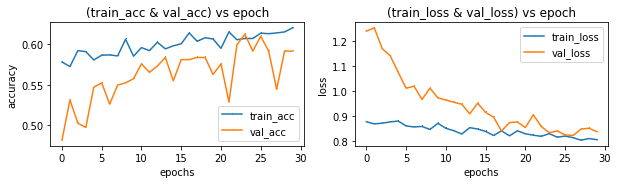

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [65]:
def plot_accuracy_loss(history):
    
    fig = plt.figure(figsize=(10,5))

    plt.subplot(221)
    #plt.plot(history.history['accuracy'],'bo--', label = "train_acc")
    plt.plot(history.history['accuracy'],marker = ',',ms = 10, label = "train_acc")
    plt.plot(history.history['val_accuracy'], marker = ',', label = "val_acc")
    plt.title("(train_acc & val_acc) vs epoch")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    plt.subplot(222)
    plt.plot(history.history['loss'],marker= ',', label = "train_loss")
    plt.plot(history.history['val_loss'], marker=',' , label = "val_loss")
    plt.title("(train_loss & val_loss) vs epoch")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    f = plt.figure()
    plt.show()
  


plot_accuracy_loss(model_history)
f = plt.figure()
f.savefig('C:/Users/Janani/GAIP_NUS/Eye Motion', bbox_inches='tight', dpi=600)

1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 42ms/step


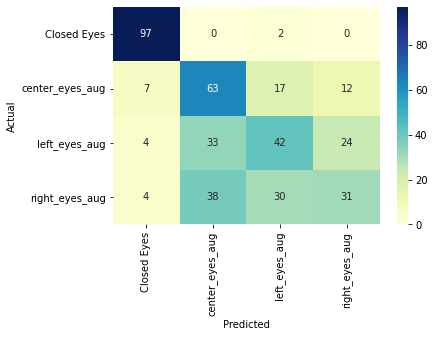

test accuracy: 57.67326732673267


In [66]:
#to plot confusion matrix for 100 epochs
import pandas as pd
import seaborn as sn
import tensorflow as tf

#model = tf.keras.models.load_model("Reflection_dataset\Saved_Model\Mobilenet_reflection.h5")
model_1 
filenames = test_generator.filenames
nb_samples = len(test_generator)
y_prob=[]
y_act=[]
test_generator.reset()
for _ in range(nb_samples):
  X_test,Y_test = test_generator.next()
  y_prob.append(model.predict(X_test))
  y_act.append(Y_test)

predicted_class = [list(train_generator.class_indices.keys())[i.argmax()]for i in y_prob]
actual_class = [list(train_generator.class_indices.keys())[i.argmax()]for i in y_act]

out_df = pd.DataFrame(np.vstack([predicted_class,actual_class]).T,columns = ['predicted_class','actual_class'])
confusion_matrix = pd.crosstab(out_df['actual_class'],out_df['predicted_class'], rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix,cmap="YlGnBu", annot = True,fmt='d')
plt.show()
print('test accuracy: {}'.format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100)))

In [71]:
y_prob[1:10]

[array([[0.0068875 , 0.15843442, 0.38061124, 0.4540669 ]], dtype=float32),
 array([[0.957233  , 0.02157165, 0.00279271, 0.01840261]], dtype=float32),
 array([[0.95022714, 0.02891321, 0.00809061, 0.01276902]], dtype=float32),
 array([[0.00444111, 0.40892076, 0.17038397, 0.41625413]], dtype=float32),
 array([[9.9973518e-01, 1.7303023e-04, 5.5684512e-05, 3.6144247e-05]],
       dtype=float32),
 array([[9.9952507e-01, 1.1538227e-04, 1.9624022e-04, 1.6336050e-04]],
       dtype=float32),
 array([[4.0662426e-06, 5.7268810e-01, 3.1869817e-01, 1.0860970e-01]],
       dtype=float32),
 array([[2.5847610e-04, 5.6250858e-01, 1.9380431e-01, 2.4342863e-01]],
       dtype=float32),
 array([[6.8953022e-06, 4.1365388e-01, 3.9313656e-01, 1.9320272e-01]],
       dtype=float32)]

In [72]:
y_act[1:10]

[array([[0., 0., 0., 1.]], dtype=float32),
 array([[1., 0., 0., 0.]], dtype=float32),
 array([[1., 0., 0., 0.]], dtype=float32),
 array([[0., 1., 0., 0.]], dtype=float32),
 array([[1., 0., 0., 0.]], dtype=float32),
 array([[1., 0., 0., 0.]], dtype=float32),
 array([[0., 1., 0., 0.]], dtype=float32),
 array([[0., 0., 0., 1.]], dtype=float32),
 array([[0., 1., 0., 0.]], dtype=float32)]

In [70]:
result = model_1.evaluate(test_generator)
dict(zip(model_1.metrics_names, result))

404/404 [==============================] - 29s 68ms/step - loss: 0.8921 - accuracy: 0.5644 - mse: 0.1331


{'loss': 0.892055869102478,
 'accuracy': 0.5643564462661743,
 'mse': 0.13314001262187958}